# The Challenge

Company XYZ sells a software for \$39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price (\$39), while a random sample of 33% users a higher price (\$59). 

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

Especially he asked you the following questions:
  * Should the company sell its software for \$39 or \$59
  * The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?
  * [Bonus] The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

# The Data

There are two tables of data.  The first, "test_results", is data decribing the test with the following collumn descriptions

  * user_id : the ID of the user. Can be joined to user_id in user_table
  * timestamp : the date and time when the user hit for the first time company XYZ
  * webpage. It is in user local time
  * source : marketing channel that led to the user coming to the site. It can be:
    * ads-["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from google ads, yahoo ads, etc.
    * seo - ["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from google search, yahoo, facebook, etc.
    * friend_referral : user coming from a referral link of another user
    * direct_traffic: user coming by directly typing the address of the site on the browser
  * device : user device. Can be mobile or web
  * operative_system : user operative system. Can be: "windows", "linux", "mac" for web, and "android", "iOS" for mobile. Other if it is none of the above
  * test: whether the user was in the test (i.e. 1 -> higher price) or in control (0 -> oldlower price)
  * price : the price the user sees. It should match test
  * converted : whether the user converted (i.e. 1 -> bought the software) or not (0 -> left the site without buying it).
  
The second, "user_table", is information about the user

  * user_id : the Id of the user. Can be joined to user_id in test_results table
  * city : the city where the user is located. Comes from the user ip address
  * country : in which country the city is located
  * lat : city latitude - should match user city


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import roc_curve, auc,classification_report
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from scipy.stats import chi2_contingency
import datetime as dt
from mpl_toolkits.basemap import Basemap
#import missingno as mso
%matplotlib inline

# Data read and Peak

In [2]:
test = pd.read_csv('test_results.csv', date_parser = 'timestamp')
#test=pd.read_csv('test_results.csv', index_col=False)
#df = pd.DataFrame.from_csv('referral.csv')

print type(test.timestamp[0])
test.shape

<type 'str'>


(316800, 8)

In [3]:
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
user_id             316800 non-null int64
timestamp           316800 non-null object
source              316800 non-null object
device              316800 non-null object
operative_system    316800 non-null object
test                316800 non-null int64
price               316800 non-null int64
converted           316800 non-null int64
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


In [5]:
test['converted'].value_counts()

0    310992
1      5808
Name: converted, dtype: int64

In [6]:
#33% of users were suggested 59 price as mensioned into problem description
test['price'].value_counts()

39    202672
59    114128
Name: price, dtype: int64

In [7]:
test['test'].value_counts()

0    202727
1    114073
Name: test, dtype: int64

In [8]:
test['timestamp'].value_counts()

2015-04-12 11:51:16    12
2015-05-25 07:27:08    11
2015-04-04 17:38:26    11
2015-04-10 08:29:07    11
2015-05-29 10:07:09    10
2015-03-06 12:23:20    10
2015-03-21 18:19:19    10
2015-05-14 16:41:42    10
2015-05-01 08:20:45    10
2015-03-26 11:59:06    10
2015-04-08 05:01:05    10
2015-05-01 18:50:10    10
2015-05-15 08:47:44    10
2015-04-24 09:44:11    10
2015-03-06 17:26:54    10
2015-04-25 18:23:07    10
2015-03-17 14:05:09    10
2015-04-10 17:01:33    10
2015-03-13 17:12:13    10
2015-05-21 22:12:24    10
2015-03-20 12:40:13     9
2015-04-19 11:07:33     9
2015-05-09 05:52:57     9
2015-05-23 04:25:42     9
2015-04-24 18:31:05     9
2015-04-17 07:57:44     9
2015-03-04 12:08:54     9
2015-05-31 08:42:21     9
2015-05-29 10:04:04     9
2015-03-19 10:23:11     9
                       ..
2015-05-10 07:39:50     1
2015-05-21 18:46:47     1
2015-04-27 06:10:07     1
2015-03-24 06:44:55     1
2015-04-14 12:09:55     1
2015-03-07 22:22:45     1
2015-03-13 01:28:60     1
2015-05-12 1

In [9]:
user = pd.read_csv('user_table.csv', date_parser = 'timestamp')
#test=pd.read_csv('test_results.csv', index_col=False)
#df = pd.DataFrame.from_csv('referral.csv')
user.shape

(275616, 5)

In [10]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
user_id    275616 non-null int64
city       275616 non-null object
country    275616 non-null object
lat        275616 non-null float64
long       275616 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [11]:
user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [12]:
test_user=pd.merge(test,user,how='left',on='user_id')
test_user.shape

(316800, 12)

The null values are because there are 41184 users in test table that we don't have
their location and information in user table'

In [13]:
test_user.isnull().sum()

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41184
country             41184
lat                 41184
long                41184
dtype: int64

#### Inspect missing values

In [14]:
#mso.matrix(test_user.sample(250))

# Clean data
## Timestamps
It looks like some of the local time stamps are in a strange format (e.g. 12:60:45). These cannot be parsed by default, so let's fix these ourselves before moving on.

In [15]:
#date_parser didn't work since it was some bad data there and it is due to 
#time so we remove it by following line
test_user['timestamp'] = test_user['timestamp'].map(lambda x: x[:-9])
test_user.timestamp = pd.to_datetime(test_user.timestamp)

#test_user['timestamp'] = test_user['timestamp'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))

#test_user['timestamp'].map(lambda x: x.date())

In [16]:
price39 = test_user[test_user['price']==39]
price59 = test_user[test_user['price']==59]

In [17]:
price39.describe()

,user_id,test,price,converted,lat,long
count,202672.000000,202672.000000,202672.0,202672.000000,176376.000000,176376.000000
mean,499141.681614,0.000765,39.0,0.019889,37.097259,-93.986948
std,288608.634433,0.027644,0.0,0.139620,5.196223,18.093039
min,9.000000,0.000000,39.0,0.000000,19.700000,-157.800000
25%,249523.000000,0.000000,39.0,0.000000,33.660000,-112.240000
50%,498395.000000,0.000000,39.0,0.000000,37.715000,-88.550000
75%,748921.000000,0.000000,39.0,0.000000,40.700000,-78.910000
max,1000000.000000,1.000000,39.0,1.000000,61.180000,30.310000


In [18]:
price39['test'].value_counts()

0    202517
1       155
Name: test, dtype: int64

In [19]:
price59.describe()

,user_id,test,price,converted,lat,long
count,114128.000000,114128.000000,114128.0,114128.000000,99240.000000,99240.000000
mean,499529.354751,0.998160,59.0,0.015570,37.137310,-93.972573
std,288561.206978,0.042856,0.0,0.123806,5.233294,18.074920
min,3.000000,0.000000,59.0,0.000000,19.700000,-157.800000
25%,249529.000000,1.000000,59.0,0.000000,33.660000,-112.200000
50%,500075.000000,1.000000,59.0,0.000000,37.770000,-89.060000
75%,749181.000000,1.000000,59.0,0.000000,40.720000,-79.020000
max,999995.000000,1.000000,59.0,1.000000,61.180000,30.310000


In [20]:
price59['test'].value_counts()

1    113918
0       210
Name: test, dtype: int64

Thre are badly labeled data in test and price column because it should be tets= 0 for price=39 but as seen for 39 there is 155 and for 59 there is 20 bad labeled data. 
 Since these badly labeled users make up less than 1% of each respective group, so it's probably fine to drop these. I am dropping them because it is unclear which is incorrect, the price or the label.

In [21]:
price39_inTest= price39[price39['test']==0]
price59_inTest= price59[price59['test']==1]

In [22]:
#Testing to see how many times each user visited the website

In [23]:
print price39_inTest.user_id.count()/price39_inTest.user_id.nunique()
print price59_inTest.user_id.count()/price59_inTest.user_id.nunique()

1
1


In [24]:
price39_inTest['converted'].value_counts()

0    198487
1      4030
Name: converted, dtype: int64

In [25]:
price59_inTest['converted'].value_counts()

0    112146
1      1772
Name: converted, dtype: int64

# Devide data into diffrent Dataframes

In [26]:
df59=price59_inTest[['user_id','converted','lat','long','source','timestamp']]
df39=price39_inTest[['user_id','converted','lat','long','source','timestamp']]
df39_converted = df39[df39.converted==1]
df59_converted = df59[df59.converted==1]

# Visualize and preliminary analysis

Here is the distribution of users in both price range and which location had the most conversion 
here are the results in USA map but take a look at the locations which says USA but they are not:
    

In [27]:
(test_user[test_user['long']>-50])
#looks like st petersburg russia or somewhere in egypt gets labeled as st petersburg usa



,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
954,487530,2015-04-14,ads_facebook,mobile,iOS,1,59,0,Saint Petersburg,USA,59.93,30.31
3207,889901,2015-04-01,ads_facebook,web,windows,0,39,0,Saint Petersburg,USA,27.76,30.31
4357,735454,2015-05-16,ads-google,mobile,android,1,59,0,Saint Petersburg,USA,27.76,30.31
5021,786119,2015-03-09,seo-google,web,linux,0,39,0,Saint Petersburg,USA,27.76,30.31
5102,357058,2015-05-02,ads-yahoo,web,windows,0,39,0,Saint Petersburg,USA,59.93,30.31
5446,322909,2015-03-30,ads-google,mobile,iOS,1,59,0,Saint Petersburg,USA,27.76,30.31
7115,351134,2015-03-12,direct_traffic,mobile,iOS,0,39,0,Saint Petersburg,USA,27.76,30.31
7774,306632,2015-04-17,friend_referral,web,windows,0,39,0,Saint Petersburg,USA,59.93,30.31
8029,156284,2015-04-11,ads-google,mobile,android,0,39,0,Saint Petersburg,USA,59.93,30.31
9664,131876,2015-04-12,ads-bing,web,windows,0,39,0,Saint Petersburg,USA,27.76,30.31


In [28]:
#look at strange records that say theyre in the USA 
test_user[(test_user['lat']>50)&(test_user['long']>-100)&(test_user['long']<-50)&(test_user['lat']<60)]
#looks like hudson bay canada gets labeled as st petersburg usa

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
2717,232021,2015-04-25,ads_facebook,mobile,android,1,59,0,Saint Petersburg,USA,59.93,-82.64
3063,351219,2015-03-29,seo-google,mobile,iOS,1,59,0,Saint Petersburg,USA,59.93,-82.64
4869,24046,2015-03-22,direct_traffic,web,windows,0,39,0,Saint Petersburg,USA,59.93,-82.64
5577,150863,2015-03-28,ads-google,mobile,iOS,0,39,0,Saint Petersburg,USA,59.93,-82.64
5733,5736,2015-04-03,ads_other,mobile,android,0,39,0,Saint Petersburg,USA,59.93,-82.64
5738,185300,2015-05-22,ads-bing,mobile,iOS,0,39,0,Saint Petersburg,USA,59.93,-82.64
7092,738889,2015-03-20,seo_facebook,mobile,iOS,1,59,0,Saint Petersburg,USA,59.93,-82.64
7404,78457,2015-05-23,ads_facebook,web,windows,1,59,0,Saint Petersburg,USA,59.93,-82.64
11720,632497,2015-04-25,ads_facebook,mobile,android,1,59,0,Saint Petersburg,USA,59.93,-82.64
12716,337261,2015-05-25,friend_referral,mobile,iOS,1,59,0,Saint Petersburg,USA,59.93,-82.64


In [29]:
#look at strange records that say theyre in the USA 
test_user[(test_user['lat']<30)&(test_user['long']<-125)]
#this is hawaii, so ok...

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
947,754704,2015-05-17,ads-bing,mobile,android,1,59,0,Honolulu,USA,21.32,-157.80
1392,514440,2015-04-23,ads_other,mobile,other,1,59,0,Honolulu,USA,21.32,-157.80
1487,608983,2015-03-19,direct_traffic,mobile,android,0,39,0,Honolulu,USA,21.32,-157.80
4860,922418,2015-05-22,direct_traffic,mobile,android,0,39,0,Honolulu,USA,21.32,-157.80
5092,971769,2015-03-28,ads-yahoo,web,windows,0,39,0,Honolulu,USA,21.32,-157.80
5438,500769,2015-05-22,direct_traffic,mobile,android,0,39,0,Honolulu,USA,21.32,-157.80
6000,491348,2015-04-16,ads-google,mobile,iOS,1,59,0,Honolulu,USA,21.32,-157.80
6668,973803,2015-03-15,ads_facebook,web,windows,0,39,0,Honolulu,USA,21.32,-157.80
7820,696506,2015-04-12,ads_facebook,mobile,android,0,39,0,Honolulu,USA,21.32,-157.80
11020,496282,2015-04-21,ads-bing,web,mac,0,39,0,Honolulu,USA,21.32,-157.80


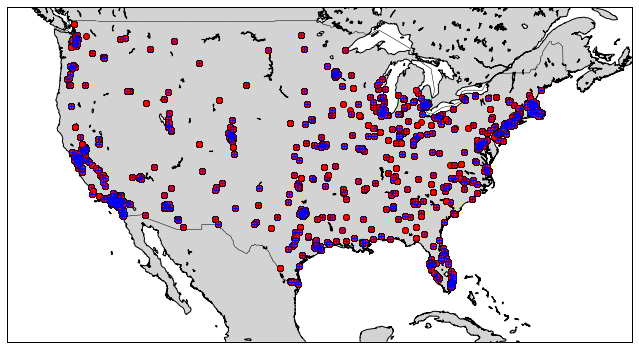

In [30]:

plt.figure(1)
plt.figure(figsize=(12,6))
map = Basemap(projection='merc',llcrnrlat=20,urcrnrlat=50,\
            llcrnrlon=-130,urcrnrlon=-60,lat_ts=20,resolution='i')

map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color='lightgray')
map.drawmapboundary()


#x,y = map(np.array(df39['long']),np.array(df39['lat']))
#map.plot(x,y,'o',color='g')
x,y = map(np.array(df39['long']),np.array(df39['lat']))
map.plot(x,y,'o',color='r')
x,y = map(np.array(df39_converted['long']),np.array(df39_converted['lat']))
map.plot(x,y,'+',color='b')
#x,y = map(np.array(definit_cancel_lon),np.array(definit_cancel_lat))
#map.plot(x,y,'o',color='r')
#x,y = map(np.array(aug_lon),np.array(aug_lat))
#map.plot(x,y,'o',color='y')
plt.show()

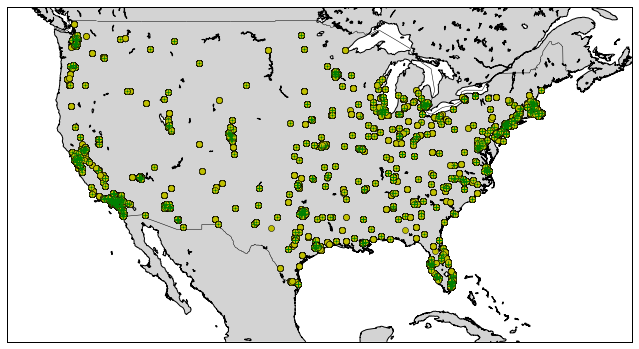

In [31]:

plt.figure(1)
# define Lambert Conformal basemap for North America.
plt.figure(figsize=(12,6))
map = Basemap(projection='merc',llcrnrlat=20,urcrnrlat=50,\
            llcrnrlon=-130,urcrnrlon=-60,lat_ts=20,resolution='i')

map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color='lightgray')
map.drawmapboundary()


x,y = map(np.array(df59['long']),np.array(df59['lat']))
map.plot(x,y,'o',color='y')
x,y = map(np.array(df59_converted['long']),np.array(df59_converted['lat']))
map.plot(x,y,'+',color='g')

plt.show()

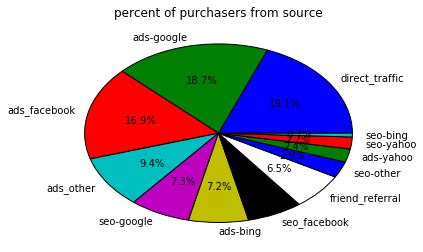

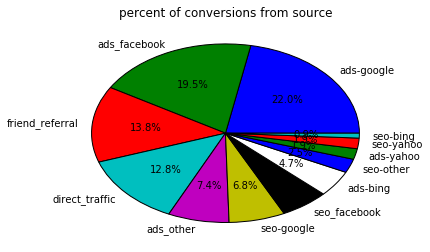

In [32]:
#show percent of purchasers from source (ignoring price changes)
sr=test_user.groupby(["source"]).agg({'user_id':'count'}).reset_index()
#print sr
sr=sr.sort_values('user_id',ascending=False).reset_index()
plt.title('percent of purchasers from source')
plt.pie(sr['user_id'],labels=sr['source'],autopct='%1.1f%%')
plt.show()



#show percent of conversions from source (ignoring any price changes)
sr=test_user.groupby(["source","converted"]).agg({'user_id':'count'}).reset_index()
sr=sr[sr['converted']==1]
sr=sr.sort_values('user_id',ascending=False).reset_index()

plt.title('percent of conversions from source')
plt.pie(sr['user_id'],labels=sr['source'],autopct='%1.1f%%')
plt.show()





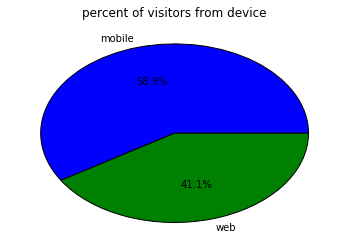

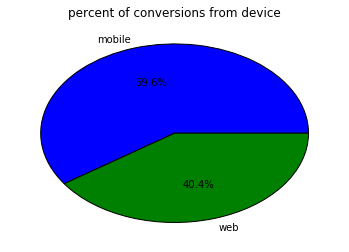

In [33]:
#show percent of purchasers from source (ignoring price changes)
sr=test_user.groupby(["device"]).agg({'user_id':'count'}).reset_index()
sr=sr.sort_values('user_id',ascending=False).reset_index()

plt.title('percent of visitors from device')
plt.pie(sr['user_id'],labels=sr['device'],autopct='%1.1f%%')
plt.show()



#show percent of conversions from source (ignoring any price changes)
sr=test_user.groupby(["device","converted"]).agg({'user_id':'count'}).reset_index()
sr=sr[sr['converted']==1]
sr=sr.sort_values('user_id',ascending=False).reset_index()

plt.title('percent of conversions from device')
plt.pie(sr['user_id'],labels=sr['device'],autopct='%1.1f%%')
plt.show()

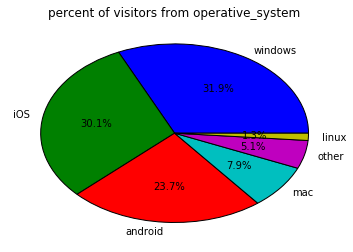

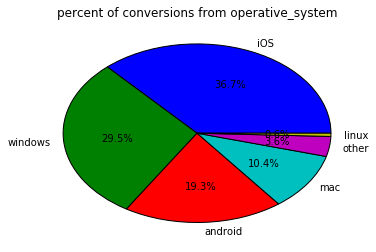

In [34]:
#show percent of purchasers from os (ignoring price changes)
sr=test_user.groupby(["operative_system"]).agg({'user_id':'count'}).reset_index()
sr=sr.sort_values('user_id',ascending=False).reset_index()

plt.title('percent of visitors from operative_system')
plt.pie(sr['user_id'],labels=sr['operative_system'],autopct='%1.1f%%')
plt.show()



#show percent of conversions from source (ignoring any price changes)
sr=test_user.groupby(["operative_system","converted"]).agg({'user_id':'count'}).reset_index()
sr=sr[sr['converted']==1]
sr=sr.sort_values('user_id',ascending=False).reset_index()

plt.title('percent of conversions from operative_system')
plt.pie(sr['user_id'],labels=sr['operative_system'],autopct='%1.1f%%')
plt.show()

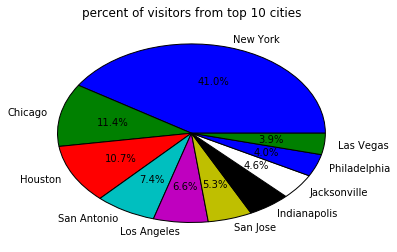

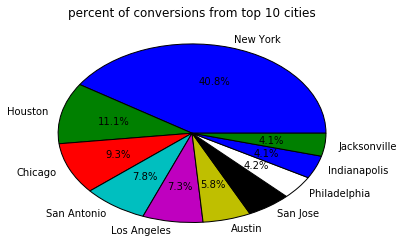

In [35]:
#show percent of purchasers from os (ignoring price changes)
sr=test_user.groupby(["city"]).agg({'user_id':'count'}).reset_index()
sr=sr.sort_values('user_id',ascending=False).reset_index()
plt.title('percent of visitors from top 10 cities')
plt.pie(sr['user_id'][0:10],labels=sr['city'][0:10],autopct='%1.1f%%')
plt.show()



#show percent of conversions from source (ignoring any price changes)
sr=test_user.groupby(["city","converted"]).agg({'user_id':'count'}).reset_index()
sr=sr[sr['converted']==1]
sr=sr.sort_values('user_id',ascending=False).reset_index()
plt.title('percent of conversions from top 10 cities')
plt.pie(sr['user_id'][0:10],labels=sr['city'][0:10],autopct='%1.1f%%')
plt.show()



#vn=zip(sr['user_id'].values,sr['city'].values)
#vn.sort(reverse=True)



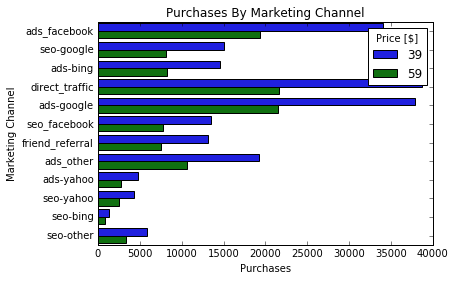

In [36]:
fig, ax = plt.subplots()
#if you put you values in y it prints like this
g = sns.countplot(y='source', hue='price',data=test_user)
ax.set(title='Purchases By Marketing Channel',xlabel='Purchases', ylabel='Marketing Channel')
l = ax.legend()
l.set_title('Price [$]')
plt.show()

In [37]:
visitors39 = price39_inTest.user_id.count()
conversions39 = price39_inTest[price39_inTest['converted']==1].user_id.count()

revenue39 = conversions39 * 39
revenue_per_visitor39=revenue39/float(visitors39)
conversion_rate39 = conversions39/float(visitors39)

print 'For the price 39 out of %d people who visited the website %d people made a purchace' %(visitors39,conversions39)
print 'vitited = %d' %visitors39
print 'converted = %d' %conversions39
no_conversions39 = (visitors39-conversions39)
print 'not_converted = %d' %no_conversions39
print 'conversion rate = %f' %conversion_rate39
print 'Revenue = %f'%revenue39
print 'Revenue/visitor = %f'%revenue_per_visitor39

For the price 39 out of 202517 people who visited the website 4030 people made a purchace
vitited = 202517
converted = 4030
not_converted = 198487
conversion rate = 0.019900
Revenue = 157170.000000
Revenue/visitor = 0.776083


In [38]:
visitors59 = price59_inTest.user_id.count()
conversions59 = price59_inTest[price59_inTest['converted']==1].user_id.count()

revenue59 = conversions59 * 59
revenue_per_visitor59=revenue59/float(visitors59)
conversion_rate59 = conversions59/float(visitors59)

print 'For the price 59 out of %d people who visited the website %d people made a purchace' %(visitors59,conversions59)
print 'vitited = %d' %visitors59
print 'converted = %d' %conversions59
no_conversions59 = (visitors59-conversions59)
print 'not_converted = %d' %no_conversions59
print 'conversion rate = %f' %conversion_rate59
print 'Revenue = %f'%revenue59
print 'Revenue/visitor = %f'%revenue_per_visitor59

For the price 59 out of 113918 people who visited the website 1772 people made a purchace
vitited = 113918
converted = 1772
not_converted = 112146
conversion rate = 0.015555
Revenue = 104548.000000
Revenue/visitor = 0.917748


We see that although the non-test set is generating more revenue, they actually contribute less revenue per user as traced by the revenue means. Thus from this preliminary analysis, it appears that this price increase may have resulted in more revenue.

Overall, we find that the lower price promotes more conversions, which is not really surprising.

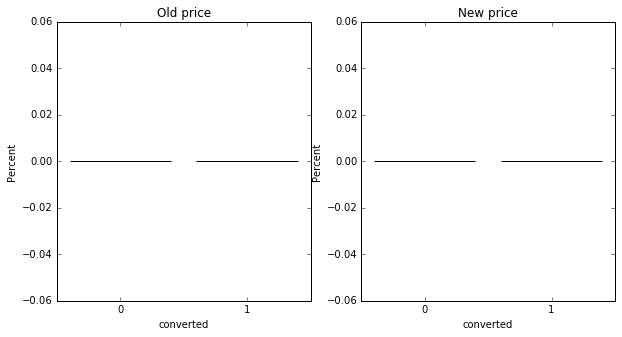

In [57]:
f = plt.figure(figsize=(10,5))
fs1 = f.add_subplot(1,2,1)
ax = sns.barplot(x="converted", y="converted", data=price39, estimator=lambda x: len(x) / len(price39) * 100)
ax.set(ylabel="Percent")
ax.set(title="Old price")

fs2 = f.add_subplot(1,2,2)
ax = sns.barplot(x="converted", y="converted", data=price59, estimator=lambda x: len(x) / len(price59) * 100)
ax.set(ylabel="Percent")
ax.set(title="New price")


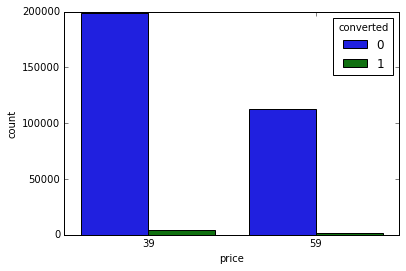

In [56]:
sns.countplot(x="price", hue="converted", data =test)

In [40]:

daily_visitors59 = df59.groupby('timestamp').user_id.count()
daily_conversions59 = df59_converted.groupby('timestamp').converted.count()
daily_revenue59 = daily_conversions59 * 59


In [41]:
daily_visitors39 = df39.groupby('timestamp').user_id.count()
daily_conversions39 = df39_converted.groupby('timestamp').converted.count()
daily_revenue39 = daily_conversions39 * 39

In [42]:
cols =['daily_visitors59','daily_visitors39','daily_conversions59','daily_conversions39','daily_revenue59','daily_revenue39']
daily_df = pd.DataFrame(columns=cols)

In [43]:
daily_df['daily_visitors59']=daily_visitors59
daily_df['daily_visitors39']=daily_visitors39
daily_df['daily_conversions59']=daily_conversions59
daily_df['daily_conversions39']=daily_conversions39
daily_df['daily_revenue59']=daily_revenue59
daily_df['daily_revenue39']=daily_revenue39


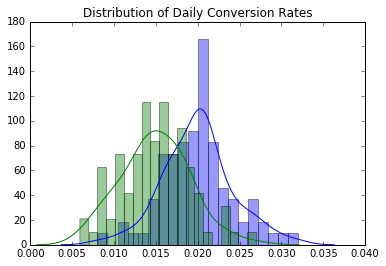

In [44]:
# plt.hist(daily_df.daily_conversions39/daily_visitors39, bins = 30, edgecolor = 'k', facecolor = 'b', alpha = 0.5, label = '$39')
# plt.hist(daily_df.daily_conversions59/daily_visitors59, bins = 30, edgecolor = 'k', facecolor = 'g', alpha = 0.5, label = '$59')
# plt.ylabel('Frequency')
# plt.xlabel('Daily Conversion Rate, %')
# plt.title('Distribution of Daily Conversion Rates' + '\n')
# plt.legend()
# plt.show()
f, ax_hist = plt.subplots(1)
sns.distplot(daily_df.daily_conversions39/daily_df.daily_visitors39, ax=ax_hist,bins=20)
sns.distplot(daily_df.daily_conversions59/daily_df.daily_visitors59, ax=ax_hist,bins=20)
ax_hist.set(title='Distribution of ' + 'Daily Conversion Rates')

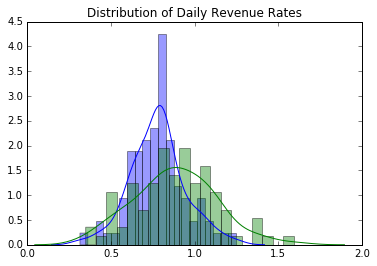

In [45]:
# plt.figure(figsize = (5,5))
# plt.hist(daily_df.daily_revenue39/daily_visitors39, bins = 30, edgecolor = 'k', facecolor = 'b', alpha = 0.5, label = '$39')
# plt.hist(daily_df.daily_revenue59/daily_visitors59, bins = 30, edgecolor = 'k', facecolor = 'g', alpha = 0.5, label = '$59')
# plt.ylabel('Frequency')
# plt.xlabel('Daily Conversion Rate, %')
# plt.title('Distribution of Daily Revenue Rates' + '\n')
# plt.legend()
# plt.show()
f, ax_hist = plt.subplots(1)
sns.distplot(daily_df.daily_revenue39/daily_visitors39, ax=ax_hist,bins=20)
sns.distplot(daily_df.daily_revenue59/daily_visitors59, ax=ax_hist,bins=20)
ax_hist.set(title='Distribution of ' + 'Daily Revenue Rates')

# Statistical Testing
Chi_squere test of independence (we also performed z-test and t-test)
and one bootstramping, 
All showed the null hypothesis ("action is independent of group") is rejected.
the results are significant enough the company should change its price

In [46]:
#Chi2-test of independence
A_visited =visitors39 
B_visited =visitors59
A_converted =conversions39
B_converted =conversions59

a = [A_converted, A_visited]
b = [B_converted, B_visited]
ab = np.array([a,b])

chi2, pvalue, _, _ = chi2_contingency(ab)
print 'chi2 = {}, p = {}'.format(chi2, pvalue)

chi2 = 73.5514903536, p = 9.80448745008e-18


In [47]:
from statsmodels.stats.proportion import proportions_ztest
count = np.array([A_converted, B_converted])
nobs = np.array([A_visited, B_visited])
stat, pval = proportions_ztest(count, nobs)
print pval

2.25492147161e-18


In [48]:
from scipy.stats import ttest_ind

conv = np.array([A_converted, B_converted])
nobs = np.array([A_visited, B_visited])

stat, pval = ttest_ind(conv, nobs)
print pval

0.0726448559947


# Frequency over time and time-series

/Users/elahe/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
/Users/elahe/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()


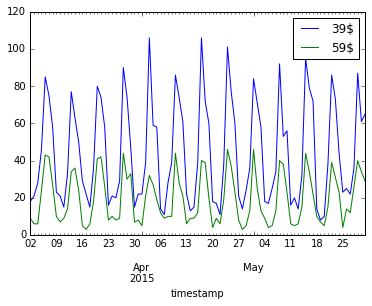

In [49]:
df39_converted.set_index('timestamp', inplace = True)
df59_converted.set_index('timestamp', inplace = True)

df39_converted.user_id.resample('D', how='count').plot()

df59_converted.user_id.resample('D', how='count').plot()

plt.legend(['39$','59$'])